# Plotting polefigures

This example shows how to plot pole figures using the built-in neml2 postprocessing regimes.  Specifically, this example load a crystal plasticity model, uses that model to generate reorientation data, and then plots two types of pole figures: discrete points and a contour plot from a reconstructed Orientation Distribution Function (ODF).  In the process then this also demonstrates how to reconstruct a continuous ODF from discrete data.

## Importing required libraries and setting up

This example will run on the GPU with CUDA if available.  `nchunk` is the chunk size for the `pyzag` integration, `ncrystal` is the number of random initial crystal orientations to use.

This example simulates rolling in an FCC material.  `rate` sets the strain rate, `total_rolling_strain` the reduction strain, and `ntime` the number of time steps to take.

In [1]:
import matplotlib.pyplot as plt
import torch
import neml2
import neml2.tensors
from pyzag import nonlinear, chunktime
import neml2.postprocessing

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

nchunk = 20
ncrystal = 500

In [3]:
rate = 0.0001
total_rolling_strain = 0.5
ntime = 2500
end_time = total_rolling_strain / rate
initial_orientations = neml2.Rot.rand((ncrystal,), ()).torch().to(device)

In [4]:
deformation_rate = torch.zeros((ntime, ncrystal, 6), device = device)
deformation_rate[:, :, 1] = rate
deformation_rate[:, :, 2] = -rate
times = torch.linspace(0, end_time, ntime, device = device).unsqueeze(-1).unsqueeze(-1).expand((ntime, ncrystal, 1))
vorticity = torch.zeros((ntime, ncrystal, 3), device = device)

## pyzag driver

For more details on the pyzag driver used here see the deterministic and stochastic inference examples.  This helper object just lets us integrate the crystal model using pyzag

In [5]:
class Solve(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """

    def __init__(self, discrete_equations, nchunk=1, rtol=1.0e-6, atol=1.0e-8):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, deformation_rate, vorticity, cache=False, initial_orientations=None):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            deformation_rate (torch.tensor): batched deformation rates
            vorticity (torch.tensor): batched vocticities

        Keyword Args:
            cache (bool): if true, cache the solution and use it as a predictor for the next call.
                This heuristic can speed things up during inference where the model is called repeatedly with similar parameter values.
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations,
            step_generator=nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(),
            nonlinear_solver=chunktime.ChunkNewtonRaphson(rtol=self.rtol, atol=self.atol),
        )

        # Setup
        forces = {
            "forces/t": neml2.Scalar(time.squeeze(-1), 0),
            "forces/deformation_rate": neml2.SR2(deformation_rate, 0),
            "forces/vorticity": neml2.WR2(vorticity, 0),
            "forces/initial_orientation": neml2.Rot(initial_orientations, 0),
        }
        forces = [forces[key] for key in self.discrete_equations.fmap]
        forces = neml2.assemble_vector(forces, self.discrete_equations.flayout).torch()
        state0 = [neml2.Tensor()] * len(self.discrete_equations.smap)
        if initial_orientations is not None:
            i = self.discrete_equations.smap.index("state/orientation")
            state0[i] = neml2.Tensor(initial_orientations, 1)
        state0 = neml2.assemble_vector(state0, self.discrete_equations.slayout).torch()

        result = nonlinear.solve_adjoint(solver, state0, len(forces), forces)

        if cache:
            self.cached_solution = result.detach().clone()

        return result

## Simulate rolling deformation

Simulate the rolling deformation and extract the final crystal orientations

In [6]:
nmodel = neml2.load_nonlinear_system("crystal.i", "eq_sys")
nmodel.to(device=device)
model = Solve(neml2.pyzag.NEML2PyzagModel(nmodel), nchunk=nchunk)

In [7]:
with torch.no_grad():
    orientations = neml2.tensors.Rot(
        model(times, deformation_rate, vorticity, initial_orientations=initial_orientations)[
            -1, :, 6:9
        ]
    )

## Plot a discrete pole figure

Use the built-in routines to plot a discerete 111 pole figure of the final orientations.

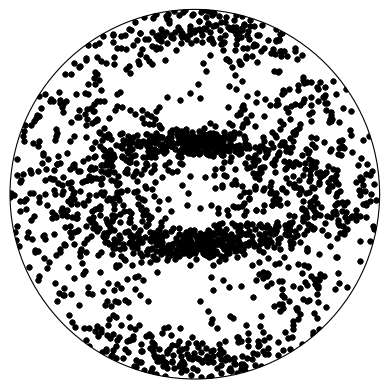

In [8]:
neml2.postprocessing.pretty_plot_pole_figure_points(
    orientations, torch.tensor([1, 1, 1.0], device=device), crystal_symmetry="432"
)

## ODF reconstruction

Reconstruct the ODF from the discrete data.  This example optimizes the kernel half-width with the build in routine (which uses a cross-validation approach).  Print the final, optimal half width.

In [9]:
odf = neml2.postprocessing.odf.KDEODF(
    orientations, neml2.postprocessing.odf.DeLaValleePoussinKernel(torch.tensor(0.1))
)
odf.optimize_kernel(verbose=True)
print(odf.kernel.h)

loss: -1.34801e+00: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Parameter containing:
tensor(0.0712, requires_grad=True)


## Plot a continuous polefigure

Use the reconstructed ODF to plot a continuous 111 polefigure

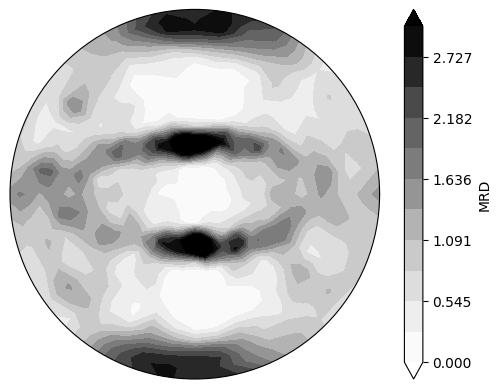

In [10]:
neml2.postprocessing.pretty_plot_pole_figure_odf(
    odf,
    torch.tensor([1, 1, 1.0], device=device),
    crystal_symmetry="432",
    limits=(0.0, 3.0),
    ncontour=12,
)